In [11]:
import sys
import numpy as np
from matplotlib import pyplot
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from icecream import ic
import pandas as pd
from math import sqrt
import glob

import random

ic("USING pytorch VERSION: ", torch.__version__)

ic| 'USING pytorch VERSION: ', torch.__version__: '1.6.0'


('USING pytorch VERSION: ', '1.6.0')

## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data is in numpy format, which conveniently pytorch has a method for converting to their native format.

The init function takes the path to the csv and creates a dataset out of it. I actually have three different options here. The dataset could be composed such that x is the 'timestamp' of the movement,the previous set of angles, or a tuple of both.

In [2]:
class AngleDataset(Dataset):
    def __init__(self, x, y):
        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE or L1 Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length


def create_datasets(csv_path: str, train_perc: float = 0.8):
    df = pd.read_csv(csv_path)
    length = len(df)
    time = 10
    timestep = 0.005

    # x_data = np.array([])
    # y_data = np.array([])
    x_data = []
    y_data = []

    sin_test_timepoints = np.random.rand(length, 1)*time   # Repeat data generation for test set
    sin_test_timepoints = sin_test_timepoints.ravel()
    sin_iter = iter(sin_test_timepoints)
    
    #data order = sin, angles, torso, touch_sens

    # if x = curr angles and y = next angles
    for i in range(len(df)):

        x = []
        y = []

        if i < length - 1:
            x = np.append(x, df.iloc[i])
            y = np.append(y, df.iloc[i+1][:-4]) # only include angles
        else:
            #since it loops anyway
            x = np.append(x, df.iloc[i])
            y = np.append(y, df.iloc[0][:-4])

        x = np.append([next(sin_iter)], x)
        
        
        x_data.append(x)
        y_data.append(y)
    
  
    x_data = np.array(x_data, dtype=np.float64)
    y_data = np.array(y_data, dtype=np.float64)

    last_train_idx = int(len(x_data) * train_perc)

    train_x = x_data[:last_train_idx]
    train_y = y_data[:last_train_idx]
    test_x = x_data[last_train_idx:]
    test_y = y_data[last_train_idx:]

    return AngleDataset(x=train_x, y=train_y), AngleDataset(x=test_x, y=test_y)



        


torch.Size([76, 33])

## Define training methods for the model
These methods use an initialized model and training data to iteratively perform the forward and backward pass of optimization. Aside from some data reformatting that depends on the input, output, and loss function, these methods will always be the same for any shallow neural network.

In [24]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()


def train(model, loader, optimizer, loss_fn, epochs=5):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1

        if e % 50 == 0:
            pass
        #   ic("Epoch: ", e+1)
        #   ic("Batches: ", batch_index)

    return losses


## Define testing methods for the model
These methods are like training, but we don't need to update the parameters of the model anymore because when we call the test() method, the model has already been trained. Instead, this method just calculates the predicted y values and returns them, AKA the forward pass.


In [25]:
def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict


def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_predict_vector


## Define plotting method for loss
This is a plotting method for looking at the behavior of the loss over training iterations.

In [26]:
def plot_loss(losses, title: str, show=True):
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.title(title)

    pyplot.plot(x_loss, losses)

    if show:
        pyplot.show()

    pyplot.close()


## Define Model Architecture
- 33 inputs = 3 joint angles per leg, 4 legs, 2 DOF per joint. 4 touch sensors. 1 sine timestamp.
- 28 outputs = *same as above, except just the joint angles*


In [27]:
class GaitModel(nn.Module):
    def __init__(self, layer_sizes):
        super(GaitModel, self).__init__()


        hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), nn.ReLU(), nn.BatchNorm1d(nl))
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # The output layer does not include an activation function.
        # See: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        tanh = torch.nn.Tanh()
        
        # Group all layers into the sequential container
        all_layers = hidden_layers + [output_layer] + [tanh]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

## Define Run function

In [28]:
def run(train_dataset, test_dataset, epochs=4, layer_sizes=[33, 31, 30, 28]):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 33
    
    data_loader_train = DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)
    
    # Define the hyperparameters
    learning_rate = 1e-3

    pytorch_model = GaitModel(layer_sizes)
    
    # Initialize the optimizer with above parameters
    optimizer = optim.Adam(pytorch_model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.MSELoss()  # mean squared error

    # Train and get the resulting loss per iteration
    loss = train(model=pytorch_model, loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn, epochs=epochs)
    

    # Test and get the resulting predicted y values
    y_predict = test(model=pytorch_model, loader=data_loader_test)

    return loss, y_predict, pytorch_model

## Create Datasets for Each Gait File

In [29]:
angles_path_windows = ".\\angle_files\\*.csv"
angles_path_mac = "./angle_files/*.csv"

names_and_ds = []

for file in glob.glob(angles_path_windows):

    name = file.split("\\")[2].split("_")[0]
    train_ds, test_ds = create_datasets(file)
    names_and_ds.append((name, train_ds, test_ds))


## Run and plot results

ic| 'Final loss:', sum(losses[-100:])/100: 0.26455939769744874


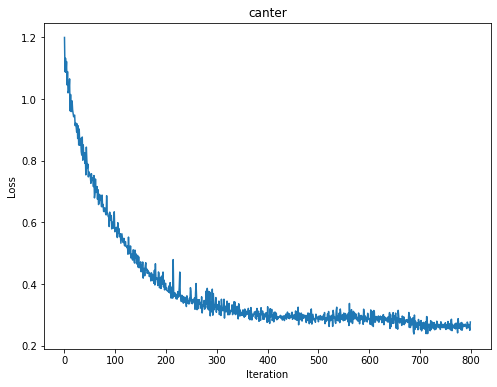

ic| sqrt(losses[-1]): 0.5260769640219087
ic| 'Final loss:', sum(losses[-100:])/100: 0.2351790711283684


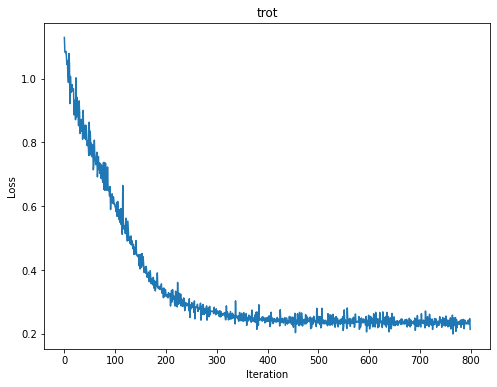

ic| sqrt(losses[-1]): 0.46243743602196974
ic| 'Final loss:', sum(losses[-100:])/100: 0.2742710575461388


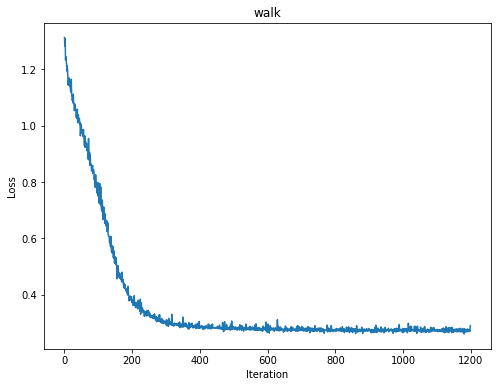

ic| sqrt(losses[-1]): 0.5394706286795569


In [30]:


for name, train_ds, test_ds in names_and_ds:

    train_ds.x_data.shape

    losses, y_predict, model_to_save = run(train_dataset=train_ds, test_dataset=test_ds, epochs=400)
    torch.save(model_to_save, f'./trained_models/{name}_model.pt')

    ic("Final loss:", sum(losses[-100:])/100)
    plot_loss(losses, name)
    ic(sqrt(losses[-1]))





In [31]:
losses

[1.3121287822723389,
 1.2810944318771362,
 1.3070238828659058,
 1.2330020666122437,
 1.2441149950027466,
 1.2392677068710327,
 1.2195059061050415,
 1.1928532123565674,
 1.2119228839874268,
 1.1987674236297607,
 1.17204749584198,
 1.143288493156433,
 1.1612157821655273,
 1.143864631652832,
 1.1687592267990112,
 1.1399121284484863,
 1.1407124996185303,
 1.1341570615768433,
 1.1227258443832397,
 1.1181418895721436,
 1.16425359249115,
 1.1167967319488525,
 1.1026345491409302,
 1.089275598526001,
 1.094306230545044,
 1.0806633234024048,
 1.1113109588623047,
 1.0784239768981934,
 1.0784815549850464,
 1.0525703430175781,
 1.0565482378005981,
 1.0760644674301147,
 1.062333583831787,
 1.0555790662765503,
 1.0509535074234009,
 1.0287200212478638,
 1.0467135906219482,
 1.0246933698654175,
 1.0578135251998901,
 1.0103782415390015,
 1.0378926992416382,
 1.0381463766098022,
 1.0101979970932007,
 1.0163156986236572,
 1.0255361795425415,
 1.0039761066436768,
 1.0102745294570923,
 0.9633687734603882,
 